# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<div style="color: #ffbbbb">
<b>ANSWER</b>: According to the "Materials and Methods" section, "the dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010."
</div>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [25]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

In [43]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [44]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<div style="color: #ffbbbb">
<b>Missing data</b>: While there are no null values in the dataset, there are values of 'unknown' in the job, marital, education, default, housing, and loan columns. A value of 'unknown' is essentially missing data, as it doesn't tell us anything.

<b>Type coercion</b>: The default, housing, and loan columns are categorical, although they should be boolean values, with the 'unknown' values removed
</div>

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

<div style="color: #ffbbbb">
The business objective is to increase efficiency for the marketing campaign. To do that, it is important to determine which factors contribute to a higher rate of success.
</div>

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [45]:
df_encoded = df.copy()

# encode binary columns
df_encoded['y'] = pd.get_dummies(df_encoded['y'])['yes']
df_encoded['default'] = pd.get_dummies(df_encoded['default'])['yes']
df_encoded['housing'] = pd.get_dummies(df_encoded['housing'])['yes']
df_encoded['loan'] = pd.get_dummies(df_encoded['loan'])['yes']

# delete rows with missing data (values of 'unknown')
df_encoded = df_encoded[df_encoded['job'] != 'unknown']
df_encoded = df_encoded[df_encoded['marital'] != 'unknown']
df_encoded = df_encoded[df_encoded['education'] != 'unknown']
df_encoded = df_encoded[df_encoded['default'] != 'unknown']
df_encoded = df_encoded[df_encoded['housing'] != 'unknown']
df_encoded = df_encoded[df_encoded['loan'] != 'unknown']

# encode categorical columns
df_encoded = pd.get_dummies(df_encoded, columns=['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome'])

In [46]:
df_encoded.head()

,age,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0,0,0,261,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
1,57,0,0,0,149,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
2,37,0,1,0,226,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
3,40,0,0,0,151,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0
4,56,0,0,1,307,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,1,0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('y', axis=1), df_encoded['y'], test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

<div style="color: #ffbbbb">
A baseline model would simply predict the mode of the outcome variable for all inputs. For this dataset, that means we would always predict that the marketing efforts were unsuccessful.
</div>

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [8]:
logreg = LogisticRegression(max_iter=10000)
start = time.perf_counter()
logreg.fit(X_train, y_train)
end = time.perf_counter()

### Problem 9: Score the Model

What is the accuracy of your model?

In [9]:
accuracy = logreg.score(X_test, y_test)
print(f'accuracy score: {accuracy}')

accuracy score: 0.9138920780711826


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [10]:
comparison_df = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

In [11]:
comparison_df.loc[0] = np.array(['Logistic Regression', (end-start), logreg.score(X_train, y_train), accuracy])
comparison_df.head()

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,5.24118004925549,0.9108828782852768,0.9138920780711826


In [12]:
# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
start = time.perf_counter()
knn.fit(X_train, y_train)
end = time.perf_counter()

comparison_df.loc[len(comparison_df)] = np.array(['KNN', (end-start), knn.score(X_train, y_train), knn.score(X_test, y_test)])

# Decision Tree
dtree = DecisionTreeClassifier()
start = time.perf_counter()
dtree.fit(X_train, y_train)
end = time.perf_counter()

comparison_df.loc[len(comparison_df)] = np.array(['Decision Tree', (end-start), dtree.score(X_train, y_train), dtree.score(X_test, y_test)])

# Support Vector Machine
svm = SVC()
start = time.perf_counter()
svm.fit(X_train, y_train)
end = time.perf_counter()

comparison_df.loc[len(comparison_df)] = np.array(['SVM', (end-start), svm.score(X_train, y_train), svm.score(X_test, y_test)])

comparison_df.head()

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,5.24118004925549,0.9108828782852768,0.9138920780711826
1,KNN,0.01196211390197277,0.9305626435315132,0.9082791172343411
2,Decision Tree,0.20760468021035194,1.0,0.8897818599311137
3,SVM,23.041767900809646,0.8975503955090585,0.9033039928562316


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

<div style="color: #ffbbbb">
The gender column has already been removed from the supplied dataset. The paper explained that the researchers removed the gender column because the success rate was essentially the same regardless of whether the customer was male or female.
</div>

In [13]:
# Tuning Logistic Regression
gridsearch_logreg = GridSearchCV(LogisticRegression(max_iter=10000), {'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2', 'elasticnet', None]}, cv=5).fit(X_train, y_train)
print(f'best parameters: {gridsearch_logreg.best_params_}')

/Users/waddledee72/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/waddledee72/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/waddledee72/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/waddledee72/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/waddledee72/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/waddledee72/anaconda3/lib/python3.11/s

best parameters: {'C': 1000, 'penalty': 'l2'}


In [14]:
# Tuning K Nearest Neighbors
gridsearch_knn = GridSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}, cv=5).fit(X_train, y_train)
print(f'best parameters: {gridsearch_knn.best_params_}')

best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'}


In [15]:
# Tuning Decision Tree
gridsearch_dtree = GridSearchCV(DecisionTreeClassifier(), {'max_depth': [1, 3, 5, 7, 9, 11, 13, 15], 'criterion': ["gini", "entropy", "log_loss"], 'min_samples_split': [2,5,10]}, cv=5).fit(X_train, y_train)
print(f'best parameters: {gridsearch_dtree.best_params_}')

best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5}


In [16]:
# Tuning Support Vector Machine
gridsearch_svm = GridSearchCV(SVC(), {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}, cv=5).fit(X_train, y_train)
print(f'best parameters: {gridsearch_svm.best_params_}')

best parameters: {'C': 1000, 'kernel': 'rbf'}


In [23]:
comparison_df_optimized = pd.DataFrame(columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score', 'ROC-AUC'])

# Logistic Regression
logreg = LogisticRegression(max_iter=10000, **gridsearch_logreg.best_params_)
start = time.perf_counter()
logreg.fit(X_train, y_train)
end = time.perf_counter()
comparison_df_optimized.loc[len(comparison_df_optimized)] = np.array(['Logistic Regression', (end-start), logreg.score(X_train, y_train), knn.score(X_test, y_test), precision_score(y_test, logreg.predict(X_test)), recall_score(y_test, logreg.predict(X_test)), f1_score(y_test, logreg.predict(X_test)), roc_auc_score(y_test, logreg.predict(X_test))])

# K Nearest Neighbors
knn = KNeighborsClassifier(**gridsearch_knn.best_params_)
start = time.perf_counter()
knn.fit(X_train, y_train)
end = time.perf_counter()

comparison_df_optimized.loc[len(comparison_df_optimized)] = np.array(['KNN', (end-start), knn.score(X_train, y_train), knn.score(X_test, y_test), precision_score(y_test, knn.predict(X_test)), recall_score(y_test, knn.predict(X_test)), f1_score(y_test, knn.predict(X_test)), roc_auc_score(y_test, knn.predict(X_test))])

# Decision Tree
dtree = DecisionTreeClassifier(**gridsearch_dtree.best_params_)
start = time.perf_counter()
dtree.fit(X_train, y_train)
end = time.perf_counter()

comparison_df_optimized.loc[len(comparison_df_optimized)] = np.array(['Decision Tree', (end-start), dtree.score(X_train, y_train), dtree.score(X_test, y_test), precision_score(y_test, dtree.predict(X_test)), recall_score(y_test, dtree.predict(X_test)), f1_score(y_test, dtree.predict(X_test)), roc_auc_score(y_test, dtree.predict(X_test))])

# Support Vector Machine
svm = SVC(**gridsearch_svm.best_params_)
start = time.perf_counter()
svm.fit(X_train, y_train)
end = time.perf_counter()

comparison_df_optimized.loc[len(comparison_df_optimized)] = np.array(['SVM', (end-start), svm.score(X_train, y_train), svm.score(X_test, y_test), precision_score(y_test, svm.predict(X_test)), recall_score(y_test, svm.predict(X_test)), f1_score(y_test, svm.predict(X_test)), roc_auc_score(y_test, svm.predict(X_test))])
comparison_df_optimized

,Model,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1 Score,ROC-AUC
0,Logistic Regression,2.773031324148178,0.9102449604490942,0.9103201939022835,0.6759259259259259,0.4209919261822376,0.5188343994314144,0.6979457622879058
1,KNN,0.15720998495817184,0.9233222760908395,0.9103201939022835,0.618840579710145,0.4925028835063437,0.5484906872190108,0.727390282831772
2,Decision Tree,0.11218355782330036,0.9230033171727482,0.9128715397372114,0.623989218328841,0.5340253748558247,0.5755127408328155,0.747004081575933
3,SVM,25.752412635833025,0.9044718040316407,0.9086618191095803,0.7323076923076923,0.27450980392156865,0.39932885906040266,0.6310156592757585


<div style="color: #ffbbbb">
In the paper, the researchers found that, based on their modeling, the SVM model resulted in best score for ROC-AUC. However, my results show the decision tree to have the overall best metrics. This could be due to differing preparations of the data.
</div>

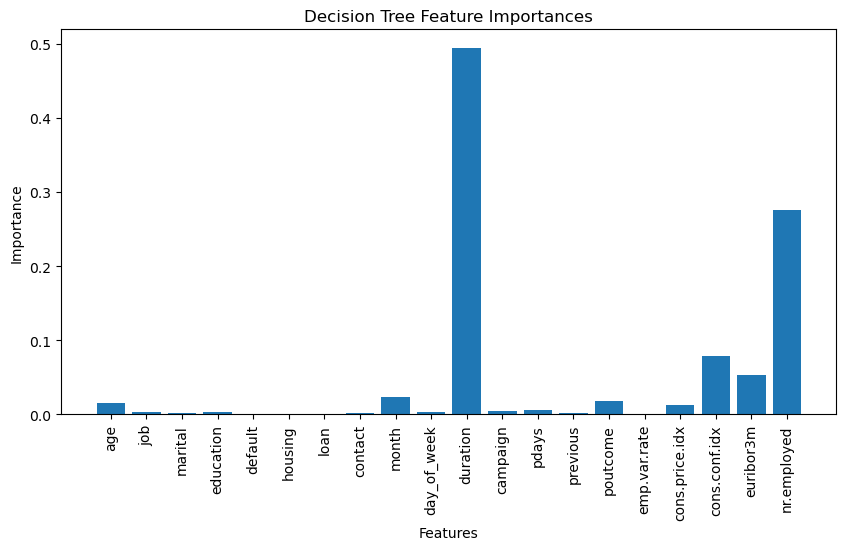

In [52]:
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
def combine_feature_importances(feature_importances):
    combined_feature_importances = [0]*(len(df.columns)-1)
    for idx, col in enumerate(X_test.columns):
        categorical = False
        for cat_col in categorical_columns:
            if col.startswith(cat_col):
                categorical = True
                # find correct index in df.columns and add to that index in combined_feature_importances
                combined_feature_importances[df.columns.get_loc(cat_col)] += feature_importances[idx]
        if not categorical:
            combined_feature_importances[df.columns.get_loc(col)] = feature_importances[idx]
    return combined_feature_importances
    
plt.figure(figsize=(10,5))
plt.bar(df.drop('y', axis=1).columns, combine_feature_importances(dtree.feature_importances_))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importances')
plt.xticks(rotation=90)
plt.show()

<div style="color: #ffbbbb">
Just like in the paper, I found the most relevant score to be the duration of the call. However, unlike the paper, I found the second, third, and fourth most relevant scores to be the economic indicators `nr.employed`, `cons.conf.idx`, and `euribor3m`.
</div>